In [12]:
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score, classification_report, roc_curve, auc, confusion_matrix, roc_auc_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.naive_bayes import GaussianNB
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.neural_network import MLPClassifier
from sklearn.utils.multiclass import unique_labels


scoring = {'acc': 'accuracy',
           'prec_macro': 'precision_macro',
           'rec_macro': 'recall_macro',
           'f1_macro':'f1_macro'}

title = 'feature20_testsize0.3'
KFOLD = 10
N_JOBS = 10

def preprocess(countpath, testsize = 0.2):
    x = pd.read_csv('%s' % countpath, index_col=0).T

    # get feature names
    featurenames = np.array(x.index)

    # get label names
    x = x.T
    y = list(np.array(x.index))
    label = sorted(list(set(y)), key = y.index)
    
    df = x
    df['target'] = y

    for classname in label:
        count_temp = len(df[df.target == classname])
        print("Proportion of family {0}: {1:.2f}%".format(classname, (count_temp / (len(df.target)) * 100)))


    y = df.target.values
    x= df.drop(['target'], axis=1)
    
#     x = x.drop(['A', 'C', 'G', 'U'], axis = 1)
    x = (x - np.min(x)) / (np.max(x) - np.min(x)).values
    
    # Normalize
#     x= x.apply(lambda x :(x-np.min(x))/(np.max(x)-np.min(x)))
    
    x = x.dropna(axis=1, how='any')  # drop all rows that have any NaN value
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = testsize, random_state = 1)

    return x_train, y_train, x_test, y_test, featurenames, label, df

def heat_norm_col(label, featurenames, x_train, counting):
    heat = pd.DataFrame(0, index=np.arange(len(label)), columns=np.arange(featurenames.size))
    heat.index = label
    heat.columns = featurenames
    for i in range(0, len(x_train.index)):
        for j in range(0, len(x_train.columns)):
            heat.loc[x_train.index[i], x_train.columns[j]] = heat.loc[x_train.index[i], x_train.columns[j]] + x_train.iloc[i, j]


    heat_norm = heat
    for i in range(0, len(heat_norm.index)):
        for j in range(0, len(heat_norm.columns)):
            heat_norm.iloc[i, j] = heat_norm.iloc[i, j] / counting[heat_norm.index[i]]

    fig, ax = plt.subplots(figsize=(10,15), dpi = 220)         # Sample figsize in inches
    # Now if we normalize it by column:
    heat_norm_col = heat_norm
    heat_norm_col=(heat_norm_col-heat_norm_col.mean())/heat_norm_col.std()

    return heat_norm_col

def plot_conusion_matrix(model,balance = 'balanced', cmap = plt.cm.Blues, normalize = True):
    model.fit(x_train, y_train)
    pred = model.predict(x_test)
    confusion = confusion_matrix(y_test, pred)

    ax = plot_con_matrix(confusion, label, normalize=normalize, title = 'Confusion matrix, with normalization of %s %s' % (balance, model) , cmap = cmap)

    plt.show()
    plt.savefig('./Prediction_output_%s/confusion_matrix_%s.png' % (title, model), format='png')


def plot_feature_distribution_heatmap(heat_norm_col,label, cmp = plt.cm.Blues):
    
    ax = plot_con_matrix(heat_norm_col.T, label, normalize = False, title = 'Normalized feature distribution of every family', cmap = cmp)
    plt.show()
    plt.savefig('./Prediction_output_%s/feature_distribution_%s.png' % (title, model), format='png')

    
def plot_con_matrix(cm, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    SMALL_SIZE = 9
    MEDIUM_SIZE = 15
    BIGGER_SIZE = 19

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('xtick', labelsize=11)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=11)    # fontsize of the tick labels
    
    fig, ax = plt.subplots(figsize = (16, 12), dpi = 330)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
          )
    
    fig.suptitle('%s' % title, fontsize=BIGGER_SIZE)    
    plt.xlabel('Predicted Family', fontsize=MEDIUM_SIZE)
    plt.ylabel('True Family', fontsize=MEDIUM_SIZE)
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    
    # Adjust the space between ticks and label
    ax.tick_params(axis='both', which='major', pad=5)
    
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if cm[i, j] > 0.01:
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    return ax


def counting(label, y_train):
    counting = {}
    for i in label:
        count = 0
        for j in y_train:
            if i == j:
                count = count+1        
        counting[i] = count
    print(counting)
    
    return counting


def smote_dict(label, counting):
    dict = {}
    for i in label:
        if counting[i] > 1000:
            dict[i] = counting[i]
        elif counting[i] > 700:
            dict[i] = counting[i] * 2
        elif counting[i] > 500:
            dict[i] = counting[i] * 3
        elif counting[i] > 200:
            dict[i] = counting[i] * 5
        else:
            dict[i] = counting[i] * 10
    print(dict)
    return dict


def calcu_metrix(scores):
    return (np.mean(scores['test_f1_macro']) * 0.6 + np.mean(scores['test_prec_macro'])*0.2 + np.mean(scores['test_rec_macro'])* 0.2)


def print_report(name, model, x_test, y_test):
    
    model_pred = model.predict(x_test)
    
    # f1 score
    print("f1 score of {0}: {1:.3f}".format(name, f1_score(y_test,model_pred, average = 'macro')))
    # 模型评估报告
    report = classification_report(y_test, model_pred, target_names= label, output_dict=True)
    
    dataframe = pd.DataFrame(report).transpose()
    dataframe.to_csv('./Prediction_output_%s/Classification_report/%s_%s.csv' % (title, title, name), index = False)

    print("Classification report of {0}: \n{1}".format(name, classification_report(y_test, model_pred,
                                            target_names= label, digits = 3)))


def pltROC(knn, svm, random, boost, mlp, nb, x_train, y_trian, x_test, y_test, balance = 'balanced'):

    knn.fit(x_train, y_train)
    svm.fit(x_train, y_train)
    nb.fit(x_train, y_train)
    boost.fit(x_train, y_train)
    random.fit(x_train, y_train)
    mlp.fit(x_train, y_train)

    d = {knn: 'KNN', svm: 'SVM', nb: 'Naive_Bayes', boost: 'Gradient-boosting', random: 'Random forest', mlp:'Neural Network'}
    # model.predict_proba(x_test)[:,1]
    # y_test.values
    plt.figure(figsize=(24, 16))
    fig, ax = plt.subplots()
    # ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".4")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.rcParams['font.size'] = 10
    plt.title('ROC curve for cancer classifier with the feature selecting \nmethod of %s' % c[count])
    # plt.subplots_adjust(wspace=2, hspace=1, top = 1)
    plt.xlabel("FPR")
    plt.ylabel("TPR(recall)")
    plt.grid(True)
    for model in d:
        proba_rf = model.predict_proba(x_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, proba_rf)
        close_default_rf = np.argmin(np.abs(thresholds - 0.5))
        plt.plot(fpr, tpr, label='ROC Curve of %s' % d[model] + '(AUC = {:.2f})'.format(roc_auc_score(y_test, proba_rf)))
        plt.plot(fpr[close_default_rf], tpr[close_default_rf], 'o', markersize=10, fillstyle="none", c='k', mew=2)
    plt.plot(fpr[close_default_rf], tpr[close_default_rf], 'o', label = 'Thresholds 0.5 RF', markersize=10, fillstyle="none", c='k', mew=2)
    fig.tight_layout()
    plt.legend(loc=4)
    plt.savefig("../Prediction_output_%s/AUC_%s.png" % (title, balance), dpi = 300)
    plt.show()
    pass

In [13]:
# KNN Model
def KNN(x_train, y_train, x_test, y_test, strategy):

    # try ro find best k value
    best = make_pipeline(SMOTE(random_state = 5, k_neighbors = 5), KNeighborsClassifier(n_neighbors=6))
    scores = cross_validate(best, x_train, y_train, scoring = scoring, cv = KFOLD, n_jobs=N_JOBS)
    best_scores = scores
    print(6)
    print(scores)
    best_metrix = calcu_metrix(scores)
    best.fit(x_train, y_train)

    scoreList = []
    scoreList.append(best.score(x_test, y_test))
    for i in range(8, 16, 2):
        knn2 = make_pipeline(SMOTE(random_state = 5, k_neighbors = 5, sampling_strategy = strategy), KNeighborsClassifier(n_neighbors=i))  # n_neighbors means 
        scores = cross_validate(knn2, x_train, y_train, scoring = scoring, cv = KFOLD, n_jobs=N_JOBS)
        temp_metrix = calcu_metrix(scores)
        print(i)
        print(scores)
        if temp_metrix > best_metrix:
            best = knn2
            best_scores = scores
        knn2.fit(x_train, y_train)
        scoreList.append(knn2.score(x_test, y_test))

    
    plt.plot(range(6, 16, 2), scoreList)
    plt.xticks(np.arange(6, 16, 2))
    plt.xlabel("K value")
    plt.ylabel("Score")
    plt.savefig("./Prediction_output_%s/knn_iteration.png" % title)
    plt.show()
    print("Maximum KNN Acuracy Score is {:.2f}%".format((max(scoreList)) * 100))
    
    
    print_report('knn', best, x_test, y_test)
    best_scores = pd.DataFrame(best_scores).transpose()
    best_scores.to_csv('./Prediction_output_%s/knn_cross_validation_score.csv' % title, index=True)

    return best

def KNN_im(x_train, y_train, x_test, y_test):

    # try ro find best k value
    best = KNeighborsClassifier(n_neighbors=6)
    scores = cross_validate(best, x_train, y_train, scoring = scoring, cv = KFOLD, n_jobs=N_JOBS)
    best_scores = scores
    print(6)
    print(scores)
    best_metrix = calcu_metrix(scores)
    best.fit(x_train, y_train)

    scoreList = []
    scoreList.append(best.score(x_test, y_test))
    for i in range(8, 16, 2):
        knn2 = KNeighborsClassifier(n_neighbors=i)  # n_neighbors means 
        scores = cross_validate(knn2, x_train, y_train, scoring = scoring, cv = KFOLD, n_jobs=N_JOBS)
        temp_metrix = calcu_metrix(scores)
        print(i)
        print(scores)
        if temp_metrix > best_metrix:
            best = knn2
            best_scores = scores
        knn2.fit(x_train, y_train)
        scoreList.append(knn2.score(x_test, y_test))
        

    plt.plot(range(6, 16, 2), scoreList)
    plt.xticks(np.arange(6, 16, 2))
    plt.xlabel("K value")
    plt.ylabel("Score")
    plt.savefig("./Prediction_output_%s/knn_im_iteration.png" % title)
    plt.show()

    print("Maximum KNN_im Acuracy Score is {:.2f}%".format((max(scoreList)) * 100))
    
    print_report('knn_im', best, x_test, y_test)
    best_scores = pd.DataFrame(best_scores).transpose()
    best_scores.to_csv('./Prediction_output_%s/knn_im_cross_validation_score.csv' % title, index=True)

 
    return best

In [14]:
def svm(x_train, y_train,x_test, y_test, strategy):
    
    best = make_pipeline(SMOTE(random_state = 5, sampling_strategy = strategy), SVC(cache_size=4096, kernel='linear'))
    best_metrix = 0
    scoreList = []
    for i in ('poly', 'rbf'):
        svm = make_pipeline(SMOTE(random_state = 5, sampling_strategy = strategy), SVC(cache_size=4096, kernel='%s' % i, probability = True, class_weight = 'balanced'))
        scores = cross_validate(svm, x_train, y_train, scoring = scoring, cv = 10, n_jobs=10)
        temp_metrix = calcu_metrix(scores)
        print(i)
        print(scores)
        if temp_metrix > best_metrix:
            best = svm
            best_scores = scores
        svm.fit(x_train, y_train)
        scoreList.append((i, svm.score(x_test, y_test)))
        
    print("Maximum kernel Score is {:.2f}%".format((max([x[1] for x in scoreList])) * 100))
    
    best_scores = pd.DataFrame(best_scores).transpose()
    best_scores.to_csv('./Prediction_output_%s/svm_cross_validation_score.csv' % title, index=True)
    print_report('svm', best, x_test, y_test)

    return best

def svm_im(x_train, y_train,x_test, y_test):

    best = SVC(cache_size=4096, kernel='linear')
    best_metrix = 0
    
    # try to find the best kernel
    scoreList = []
    for i in ('poly', 'rbf'):
        svm = SVC(cache_size=4096, kernel='%s' % i, probability = True)
        scores = cross_validate(svm, x_train, y_train, scoring = scoring, cv = 10, n_jobs=10)
        temp_metrix = calcu_metrix(scores)
        print(i)
        print(scores)
        if temp_metrix > best_metrix:
            best = svm
            best_scores = scores
        svm.fit(x_train, y_train)
        scoreList.append((i, svm.score(x_test, y_test)))


    plt.title('Various kernels of SVM algorithms')
    plt.plot([x[0] for x in scoreList], [x[1] for x in scoreList])
    plt.xticks([x[0] for x in scoreList])
    plt.xlabel("Kernel")
    plt.ylabel("Score")
    plt.savefig("./Prediction_output_%s/svm_im_kernel.png" % title)
    plt.show()
    print("Maximum kernel Score is {:.2f}%".format((max([x[1] for x in scoreList])) * 100))

    best_scores = pd.DataFrame(best_scores).transpose()
    best_scores.to_csv('./Prediction_output_%s/svm_im_cross_validation_score.csv' % title, index=True)
    print_report('svm', best, x_test, y_test)

    return best

In [15]:
def random_forest(x_train, y_train, x_test, y_test, strategy, class_weight = None):
    
    #使用网格搜索 查找最优参数
    
#     param_grid = [{'randomforestclassifier__n_estimators': [2000, 1000, 500],
#                'randomforestclassifier__max_features': [50, 30],
#                'randomforestclassifier__max_depth': [20, 15, 10]}]
    
    param_grid = [{'randomforestclassifier__n_estimators': [1000],
                   'randomforestclassifier__max_depth': [20]}]

    best = make_pipeline(SMOTE(random_state = 1, sampling_strategy = strategy), RandomForestClassifier(n_jobs=10, n_estimators = 1000, max_depth = 20, class_weight = class_weight))
#     grid_search = GridSearchCV(best, param_grid, cv=5, n_jobs=-1)
#     grid_search.fit(x_train, y_train)

#     best_scores = cross_validate(best, x_train, y_train, scoring = scoring, cv = 10, n_jobs=-1)
    
#     print(scores)
    best.fit(x_train, y_train)
    print("Test score: {:.2f}".format(best.score(x_test, y_test)))
    
#     best_scores = pd.DataFrame(best_scores).transpose()
#     best_scores.to_csv('./Prediction_output/svm_im_cross_validation_score.csv', index=True)
    print_report('random_forest', best, x_test, y_test)

    return best

def random_forest_im(x_train, y_train, x_test, y_test, class_weight = None):

    #使用网格搜索 查找最优参数
    
#     param_grid = [{'randomforestclassifier__n_estimators': [2000, 1000, 500],
#                'randomforestclassifier__max_features': [50, 30],
#                'randomforestclassifier__max_depth': [20, 15, 10]}]
    
    best_tested_param_grid = [{'randomforestclassifier__n_estimators': [1000],
                   'randomforestclassifier__max_depth': [20]}]

    best = RandomForestClassifier(n_jobs=10, n_estimators = 1000, max_depth = 20, class_weight = class_weight)
    best.fit(x_train, y_train)
#     grid_search = GridSearchCV(best, param_grid, cv=5, n_jobs=-1)
#     grid_search.fit(x_train, y_train)

#     scores = cross_validate(best, x_train, y_train, scoring = scoring, cv = 10, n_jobs=-1)
    
#     print(scores)
#     print("parameters: ", grid_search.best_params_)
    print("Test score: {:.2f}".format(best.score(x_test, y_test)))
    
#     best_scores = pd.DataFrame(best_scores).transpose()
#     best_scores.to_csv('./Prediction_output/random_forest_im_cross_validation_score.csv', index=True)
    print_report('random_forest', best, x_test, y_test)
    
    return best

In [16]:
def mlp(x_train, y_train, x_test, y_test, strategy):
    mlp = make_pipeline(SMOTE(random_state = 1, sampling_strategy = strategy), MLPClassifier(hidden_layer_sizes=(150,150,150), max_iter=500, alpha=0.0001,
                     solver='adam',tol=0.000000001))
    mlp.fit(x_train, y_train)
    print("Accuracy of mlp model is {:.3f}".format(mlp.score(x_test, y_test)))
    proba = mlp.predict_proba(x_test)
    # log_proba = mlp.predict_log_proba(x_test)
    print(mlp.predict(x_test))
    pred_mlp = mlp.predict(x_test)
    print((pred_mlp == y_test).sum() / y_test.size)
    
    print_report('mlp', mlp, x_test, y_test)
    return mlp

def mlp_im(x_train, y_train, x_test, y_test):
    mlp_im = MLPClassifier(hidden_layer_sizes=(150,150,150), max_iter=500, alpha=0.0001,
                     solver='adam', tol=0.00000001)
    mlp_im.fit(x_train, y_train)
    print("Accuracy of mlp_im imbalance model is {:.3f}".format(mlp_im.score(x_test, y_test)))
    proba = mlp_im.predict_proba(x_test)
    # log_proba = mlp_im.predict_log_proba(x_test)
    print(mlp_im.predict(x_test))
    pred_mlp_im = mlp_im.predict(x_test)
    print((pred_mlp_im == y_test).sum() / y_test.size)

    print_report('mlp', mlp, x_test, y_test)
    return mlp_im

In [17]:
def naive_bayes(x_train, y_train, x_test, y_test, strategy):
    nb = make_pipeline(SMOTE(random_state = 5, sampling_strategy = strategy), GaussianNB(var_smoothing=1e-16))
    nb.fit(x_train, y_train)
#     scores = cross_validate(nb, x_train, y_train, scoring = scoring, cv = 10)
#     print(scores)
    print("Accuracy of Naive Bayes: {:.2f}%".format(nb.score(x_test,y_test)*100))

    print_report('nb', nb, x_test, y_test)
    
#     scores = pd.DataFrame(scores).transpose()
#     scores.to_csv('./Prediction_output/nb_cross_validation_score.csv', index=True)
    
    return nb

def naive_bayes_im(x_train, y_train, x_test, y_test):
    nb = GaussianNB(var_smoothing=1e-16)
    nb.fit(x_train, y_train)
#     scores = cross_validate(nb, x_train, y_train, scoring = scoring, cv = 10)
#     print(scores)
    print("Accuracy of Naive Bayes: {:.2f}%".format(nb.score(x_test, y_test)*100))

    print_report('nb', nb, x_test, y_test)
#     scores = pd.DataFrame(scores).transpose()
#     scores.to_csv('./Prediction_output/nb_cross_validation_score.csv', index=True)
    
    return nb

In [18]:
def gradient_boosting(x_train, y_train, x_test, y_test, strategy):


    # 网格搜索算法查询最优参数（n_estimators 树个数；learning_rate 学习率； max_depth 树深度 ）
    # params_gbrt = [{
    #     'gradientboostingclassifier__n_estimators':[500,1000,2000],
    #     'gradientboostingclassifier__learning_rate':[0.01,0.1,0.05],
    #     'gradientboostingclassifier__max_depth':[7, 9, 11]
    # }]

    params_gbrt = {
        'n_estimators':1000,
        'learning_rate':0.05,
        'max_depth': 13
    }

    # gbrt_grid = GridSearchCV(gbrt, params_gbrt, cv=5, n_jobs=10)
    # gbrt_grid.fit(x_train, y_train)
    # #gbrt.fit(x_train, y_train)

    # print('Report of gradient_boosting:\n')
    # print("Best cross-validation score: {:.2f}".format(gbrt_grid.best_score_))
    # print("Best parameters: ", gbrt_grid.best_params_)
    # print("Accuracy on training set:{:.3f}".format(gbrt_grid.score(x_train, y_train)))
    # print("Accuracy on test set:{:.3f}".format(gbrt_grid.score(x_test, y_test)))

    ## 使用gbrt的最优参数构建模型 并评估模型性能
    # best_params_gbrt = gbrt_grid.best_params_

    gbrt_model = make_pipeline(SMOTE(random_state = 1, sampling_strategy = dict), GradientBoostingClassifier(**params_gbrt))
    gbrt_model.fit(x_train, y_train)
    
    print("Accuracy on test set:{:.3f}".format(gbrt_model.score(x_test, y_test)))
    print_report('gb', gbrt_model, x_test, y_test)

    return gbrt_model

def gradient_boosting_im(x_train, y_train, x_test, y_test):
    
    params_gbrt = {
        'n_estimators':1000,
        'learning_rate':0.05,
        'max_depth': 13
    }

#     gbrt_grid = GridSearchCV(gbrt, params_gbrt, cv=5, n_jobs=5)
#     gbrt_grid.fit(x_train, y_train)
    #gbrt.fit(x_train, y_train)

#     print('Report of gradient_boosting:\n')
#     print("Best cross-validation score: {:.2f}".format(gbrt_grid.best_score_))
#     print("Best parameters: ", gbrt_grid.best_params_)
#     print("Accuracy on training set:{:.3f}".format(gbrt_grid.score(x_train, y_train)))
#     print("Accuracy on test set:{:.3f}".format(gbrt_grid.score(x_test, y_test)))

#     ## 使用gbrt的最优参数构建模型 并评估模型性能
#     best_params_gbrt = gbrt_grid.best_params_

    gbrt_model = GradientBoostingClassifier(**params_gbrt)
    gbrt_model.fit(x_train, y_train)
    
#     scores = cross_validate(gbrt_model, x_train, y_train, scoring = scoring, cv = 10, n_jobs=10)
    print("Accuracy on train set:{:.3f}".format(gbrt_model.score(x_test, y_test)))
    print("Accuracy on test set:{:.3f}".format(gbrt_model.score(x_test, y_test)))

    print_report('gbrt', gbrt_model, x_test, y_test)

    return gbrt_model    # 梯度提升回归树  GBRT

Proportion of family RF00050: 7.48%
Proportion of family RF00059: 22.34%
Proportion of family RF00162: 7.67%
Proportion of family RF00167: 5.02%
Proportion of family RF00168: 2.11%
Proportion of family RF00174: 26.48%
Proportion of family RF00234: 1.70%
Proportion of family RF00380: 1.34%
Proportion of family RF00504: 13.13%
Proportion of family RF00521: 1.03%
Proportion of family RF00522: 0.72%
Proportion of family RF00634: 1.33%
Proportion of family RF01051: 6.30%
Proportion of family RF01054: 0.24%
Proportion of family RF01055: 1.87%
Proportion of family RF01057: 1.22%
{'RF00050': 836, 'RF00059': 2519, 'RF00162': 879, 'RF00167': 570, 'RF00168': 241, 'RF00174': 3016, 'RF00234': 200, 'RF00380': 151, 'RF00504': 1481, 'RF00521': 109, 'RF00522': 77, 'RF00634': 149, 'RF01051': 708, 'RF01054': 32, 'RF01055': 221, 'RF01057': 139}
{'RF00050': 1672, 'RF00059': 2519, 'RF00162': 1758, 'RF00167': 1710, 'RF00168': 1205, 'RF00174': 3016, 'RF00234': 2000, 'RF00380': 1510, 'RF00504': 1481, 'RF00521'

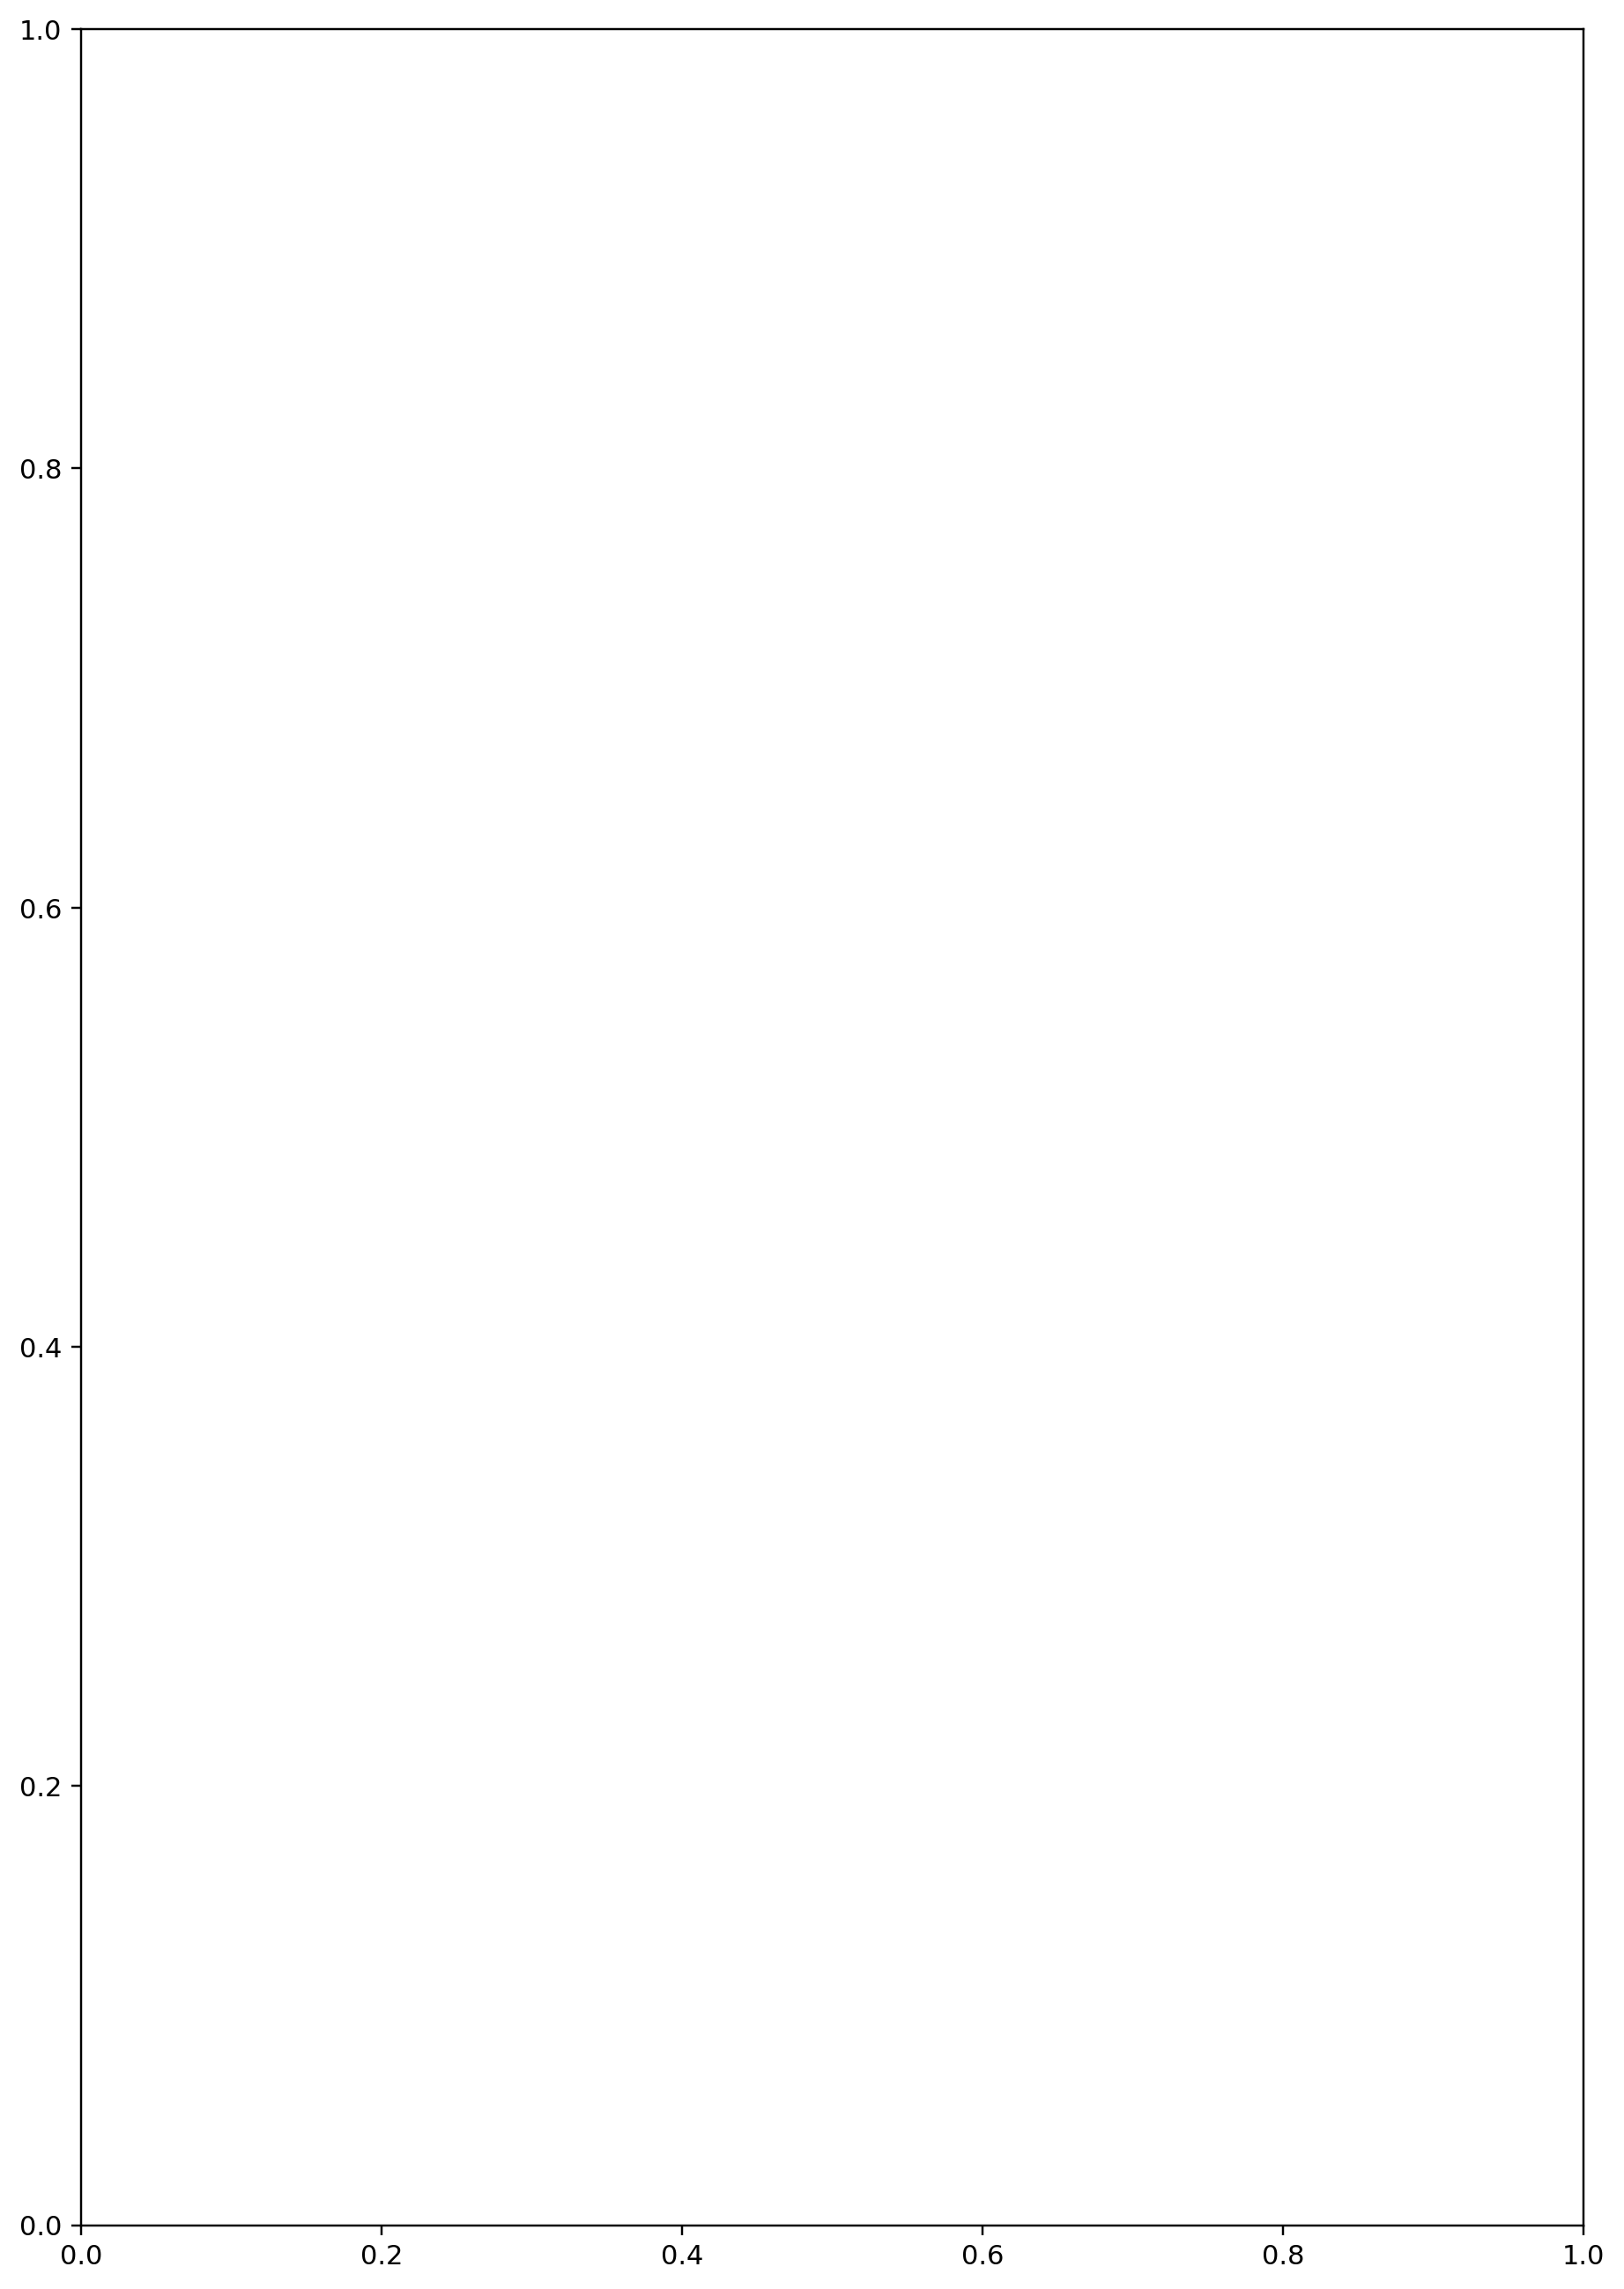

In [8]:
if __name__ == '__main__':
    countpath = './Highfrequencies.csv'

    x_train, y_train, x_test, y_test, featurenames, label, dataframe = preprocess(countpath, 0.3)

    count = counting(label, y_train)
    dict = smote_dict(label, count)
    heat_norm = heat_norm_col(label, featurenames, x_train, count)
    

Confusion matrix, without normalization


KeyError: (0, 0)

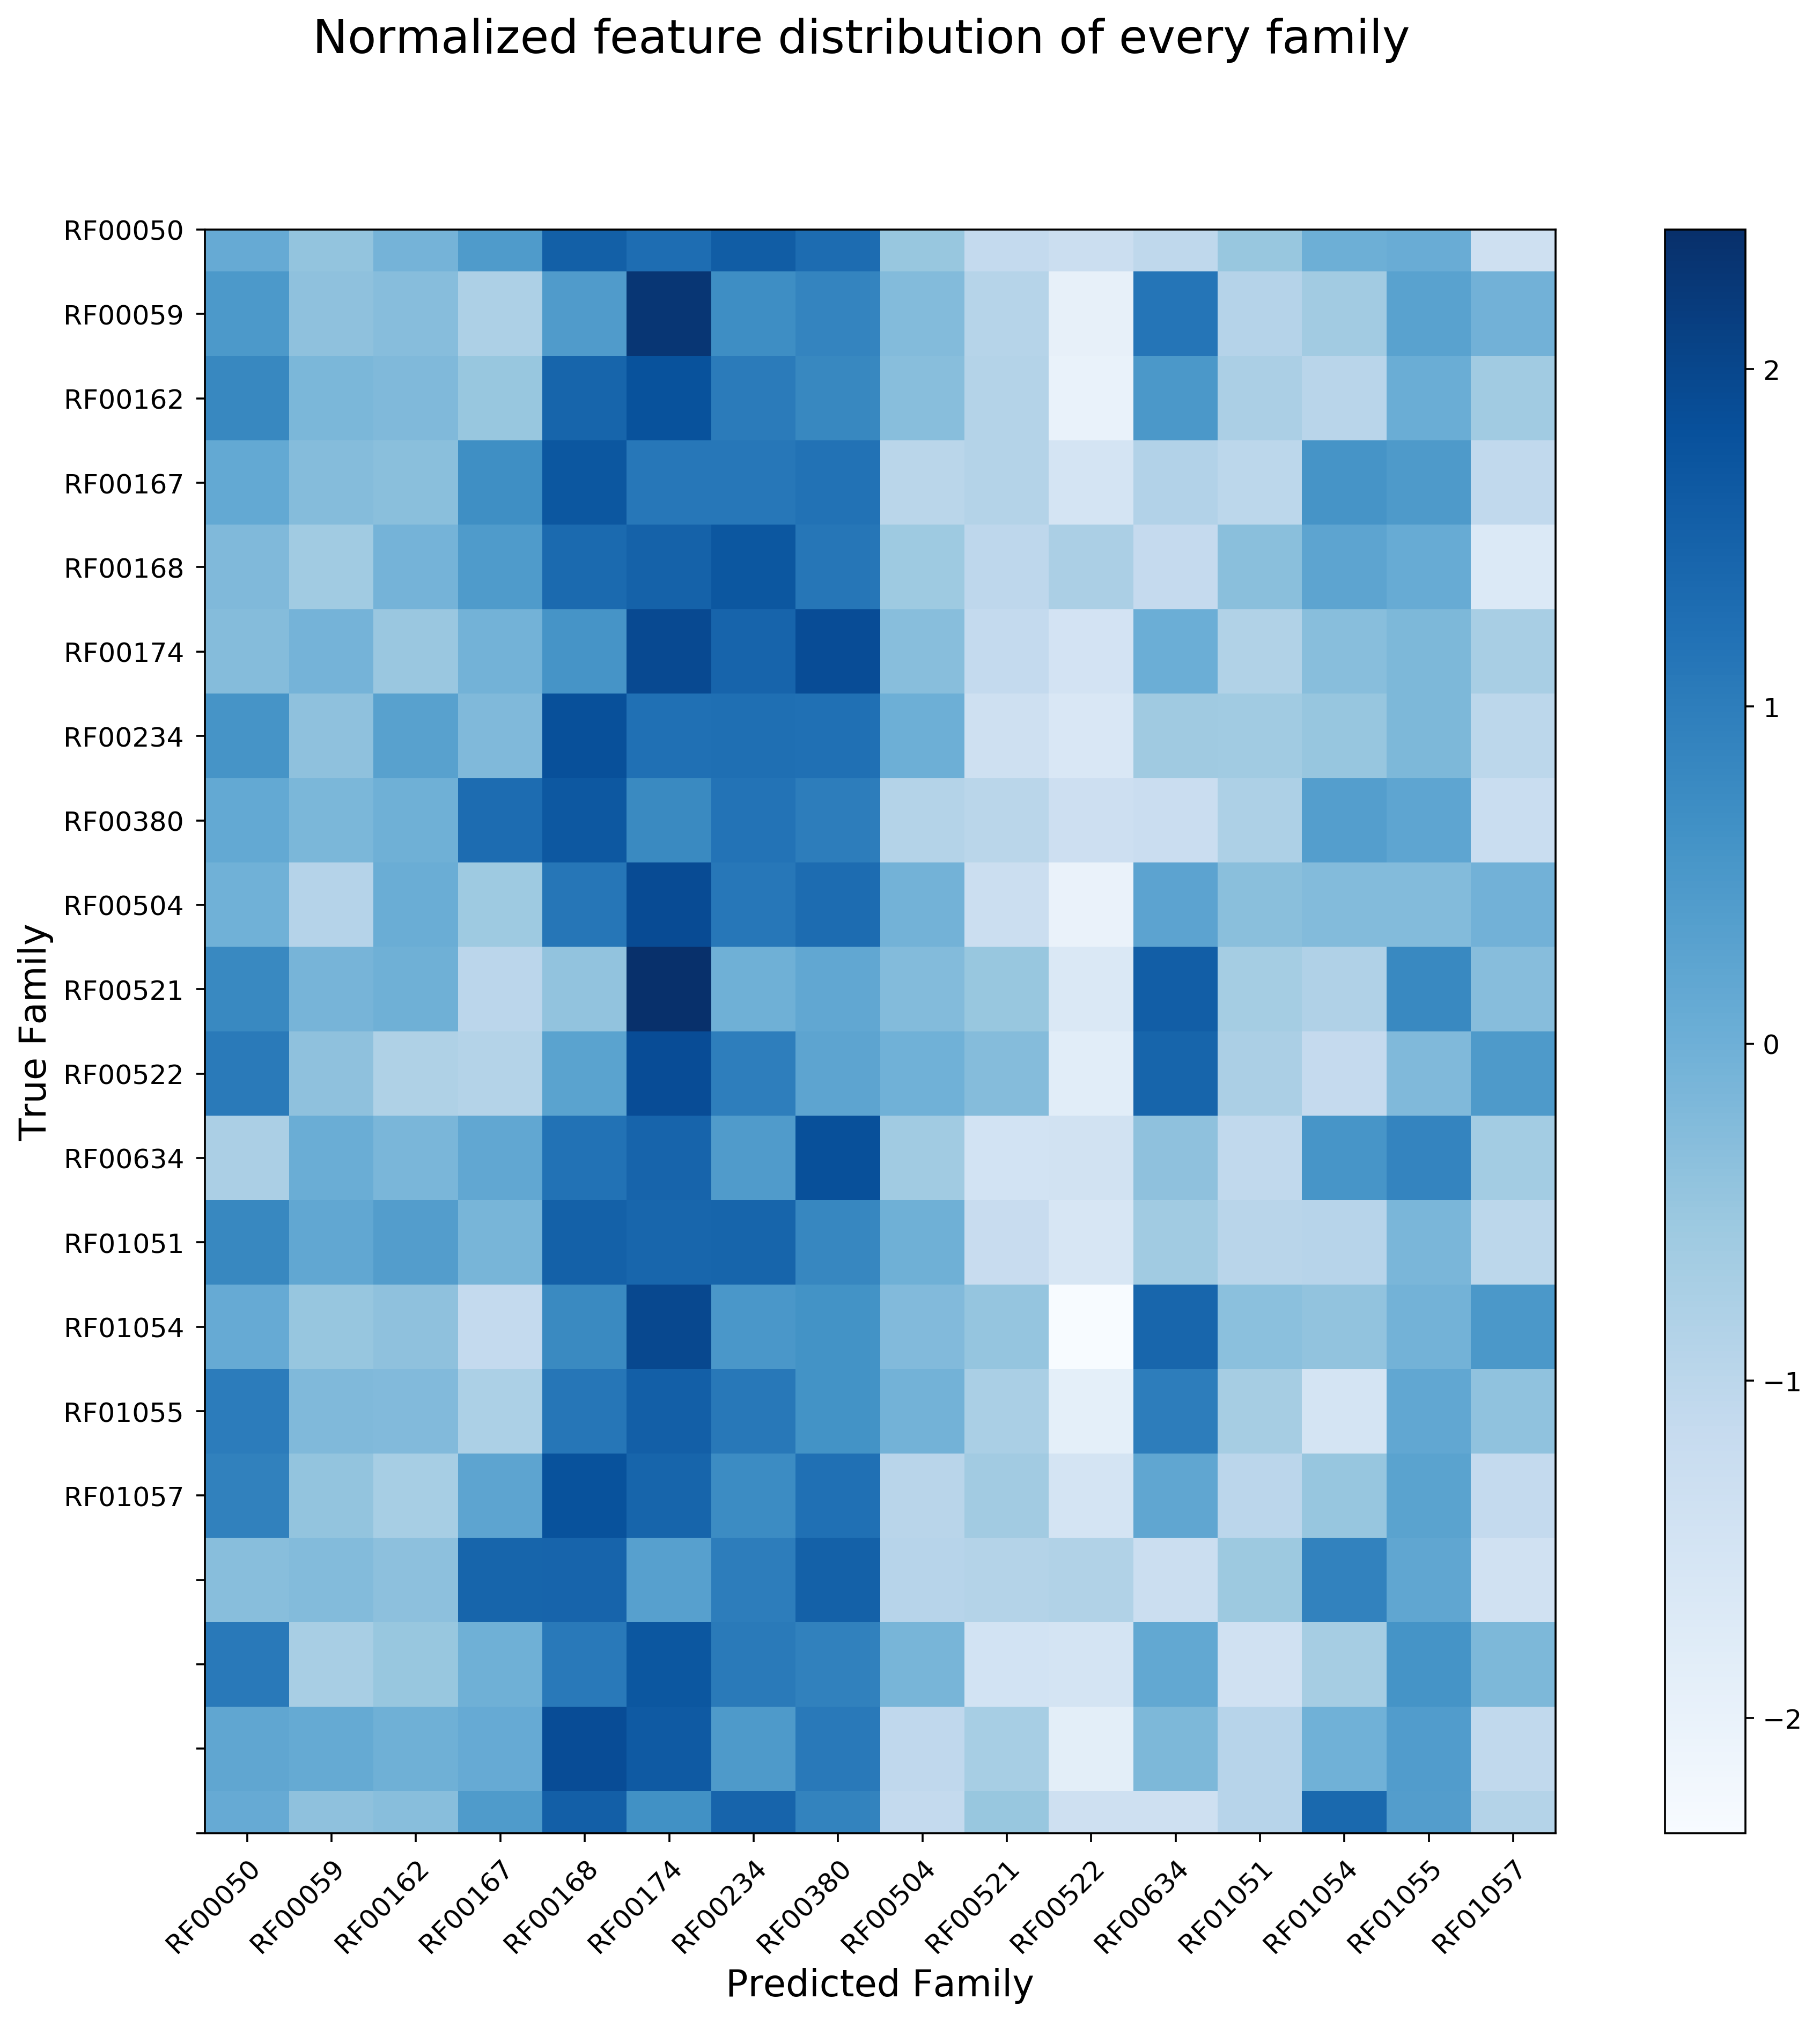

In [10]:
plot_feature_distribution_heatmap(heat_norm, label)

In [79]:
type(heat_norm)

pandas.core.frame.DataFrame

In [44]:
pltROC(knn, svm, random, gb, mlp, nb, balance = 'balanced', x_train, y_trian, x_test, y_test)
pltROC(knn, svm, random, gb, mlp, nb, balance = 'imbalanced', x_train, y_trian, x_test, y_test)

{'RF00050': 1672, 'RF00059': 2519, 'RF00162': 1758, 'RF00167': 1710, 'RF00168': 1205, 'RF00174': 3016, 'RF00234': 2000, 'RF00380': 1510, 'RF00504': 1481, 'RF00521': 1090, 'RF00522': 770, 'RF00634': 1490, 'RF01051': 1416, 'RF01054': 320, 'RF01055': 1105, 'RF01057': 1390}


## KNN model test

knn
----------------------------------------------------------------
6
{'fit_time': array([0.50902033, 0.51791859, 0.5206306 , 0.51871657, 0.5100472 ,
       0.50976205, 0.5266366 , 0.51368761, 0.51838541, 0.523947  ]), 'score_time': array([3.64308214, 3.49325609, 3.50337911, 3.61867499, 3.40228558,
       3.50876808, 3.45860767, 3.54559088, 3.50722885, 3.48703218]), 'test_acc': array([0.73397717, 0.70837004, 0.7292769 , 0.70194004, 0.72222222,
       0.74691358, 0.71996466, 0.71706454, 0.72654867, 0.69688889]), 'test_prec_macro': array([0.65340008, 0.59044492, 0.6023691 , 0.58193291, 0.59803102,
       0.6191882 , 0.6035532 , 0.58776031, 0.6198296 , 0.58225231]), 'test_rec_macro': array([0.79337869, 0.74793464, 0.779839  , 0.7655383 , 0.76160085,
       0.77970466, 0.76420995, 0.7448058 , 0.77660071, 0.71734972]), 'test_f1_macro': array([0.69878714, 0.64192463, 0.65972102, 0.64009141, 0.65161779,
       0.67348044, 0.65595898, 0.63794029, 0.6729167 , 0.62108958])}
8
{'fit_time': array

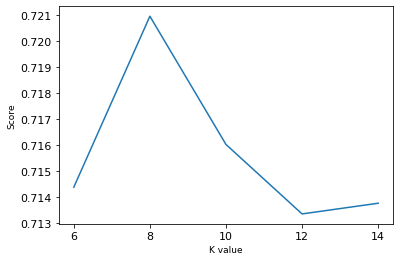

Maximum KNN Acuracy Score is 72.10%
f1 score of knn: 0.611
Classification report of knn: 
              precision    recall  f1-score   support

     RF00050      0.690     0.755     0.721       375
     RF00059      0.858     0.697     0.769      1097
     RF00162      0.537     0.699     0.607       362
     RF00167      0.663     0.852     0.746       243
     RF00168      0.371     0.530     0.436       100
     RF00174      0.953     0.717     0.819      1270
     RF00234      0.283     0.693     0.402        75
     RF00380      0.388     0.864     0.535        66
     RF00504      0.884     0.629     0.735       644
     RF00521      0.470     0.931     0.624        58
     RF00522      0.826     0.974     0.894        39
     RF00634      0.377     0.866     0.525        67
     RF01051      0.761     0.776     0.768       312
     RF01054      0.091     0.286     0.138         7
     RF01055      0.403     0.659     0.500        82
     RF01057      0.457     0.729     0.562  

In [11]:
print('knn')
print('----------------------------------------------------------------')
knn = KNN(x_train, y_train, x_test, y_test,dict)

knn_im
----------------------------------------------------------------
6
{'fit_time': array([0.02870846, 0.02881336, 0.02868176, 0.02854395, 0.03162694,
       0.02950978, 0.02897143, 0.03294373, 0.01831841, 0.03095484]), 'score_time': array([1.73350382, 1.70731354, 1.57639408, 1.76834202, 1.70872712,
       1.66907072, 1.41422534, 1.68775177, 0.93762112, 1.5811708 ]), 'test_acc': array([0.79016681, 0.76211454, 0.7989418 , 0.77160494, 0.79188713,
       0.79012346, 0.78621908, 0.77984085, 0.77433628, 0.77422222]), 'test_prec_macro': array([0.81045962, 0.77804705, 0.72288351, 0.77566474, 0.77013739,
       0.74452887, 0.73577403, 0.70597962, 0.71695834, 0.75247434]), 'test_rec_macro': array([0.66923923, 0.64111392, 0.64744   , 0.67656392, 0.69377407,
       0.68656799, 0.66618351, 0.62321432, 0.6360785 , 0.63330836]), 'test_f1_macro': array([0.70995814, 0.67831388, 0.67000635, 0.70452507, 0.71547858,
       0.70327284, 0.68195048, 0.6461592 , 0.65500134, 0.66973303])}
8
{'fit_time': ar

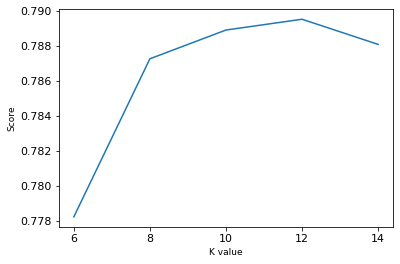

Maximum KNN_im Acuracy Score is 78.95%
f1 score of knn_im: 0.682
Classification report of knn_im: 
              precision    recall  f1-score   support

     RF00050      0.711     0.800     0.753       375
     RF00059      0.756     0.879     0.813      1097
     RF00162      0.643     0.616     0.629       362
     RF00167      0.802     0.782     0.792       243
     RF00168      0.706     0.480     0.571       100
     RF00174      0.880     0.881     0.880      1270
     RF00234      0.604     0.387     0.472        75
     RF00380      0.742     0.742     0.742        66
     RF00504      0.817     0.758     0.786       644
     RF00521      0.817     0.845     0.831        58
     RF00522      0.860     0.949     0.902        39
     RF00634      0.738     0.672     0.703        67
     RF01051      0.787     0.721     0.753       312
     RF01054      0.500     0.143     0.222         7
     RF01055      0.738     0.378     0.500        82
     RF01057      0.833     0.424   

In [12]:
print('knn_im')
print('----------------------------------------------------------------')
knn_im = KNN_im(x_train, y_train, x_test, y_test)

## SVM model test

In [13]:
print('svm')
print('----------------------------------------------------------------')
svm = svm(x_train, y_train, x_test, y_test, 'not majority')

svm
----------------------------------------------------------------
rbf
{'fit_time': array([345.73334432, 339.13725495, 303.14798951, 346.18472099,
       331.45849538, 337.04858422, 345.06930661, 336.51193094,
       325.18562341, 360.96036839]), 'score_time': array([10.87228322, 12.35617781, 11.90209699,  9.77214909,  9.73756528,
       12.0830462 , 12.0597105 , 12.00032091, 12.00958872, 10.6747129 ]), 'test_acc': array([0.66725198, 0.65726872, 0.67636684, 0.66931217, 0.670194  ,
       0.68077601, 0.64487633, 0.67374005, 0.66017699, 0.64177778]), 'test_prec_macro': array([0.56031191, 0.53129666, 0.53075023, 0.54288847, 0.53541086,
       0.53812691, 0.50405632, 0.54968245, 0.53749859, 0.52346025]), 'test_rec_macro': array([0.78056813, 0.74695726, 0.74577349, 0.76893606, 0.75779427,
       0.76428318, 0.74852698, 0.76854846, 0.7501528 , 0.73611297]), 'test_f1_macro': array([0.61249804, 0.58044296, 0.58192546, 0.59779464, 0.5872059 ,
       0.59103883, 0.5550193 , 0.59837455, 0.58486

/home/liuchong/miniconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Maximum kernel Score is 65.44%
f1 score of svm: 0.563
Classification report of svm: 
              precision    recall  f1-score   support

     RF00050      0.703     0.739     0.720       375
     RF00059      0.880     0.602     0.715      1097
     RF00162      0.527     0.610     0.566       362
     RF00167      0.588     0.605     0.596       243
     RF00168      0.302     0.800     0.438       100
     RF00174      0.958     0.640     0.767      1270
     RF00234      0.263     0.627     0.370        75
     RF00380      0.325     0.818     0.466        66
     RF00504      0.727     0.620     0.669       644
     RF00521      0.398     0.914     0.555        58
     RF00522      0.731     0.974     0.835        39
     RF00634      0.286     0.821     0.425        67
     RF01051      0.693     0.744     0.717       312
     RF01054      0.103     0.857     0.185         7
     RF01055      0.314     0.659     0.425        82
     RF01057      0.452     0.712     0.553       

svm_im
----------------------------------------------------------------
poly
{'fit_time': array([34.48267722, 35.98243952, 21.27183294, 36.074435  , 29.54841304,
       35.27238393, 30.04506755, 33.13915396, 21.43214202, 32.78291106]), 'score_time': array([2.23406649, 2.22545457, 1.6836369 , 2.20047188, 1.67106485,
       2.28653836, 1.67375827, 1.66501141, 1.64471841, 1.63078666]), 'test_acc': array([0.43195786, 0.43259912, 0.44620811, 0.4303351 , 0.43738977,
       0.4382716 , 0.43727915, 0.4403183 , 0.43893805, 0.44355556]), 'test_prec_macro': array([0.06762065, 0.06670023, 0.07002633, 0.0665173 , 0.06765713,
       0.06741942, 0.06748437, 0.0676843 , 0.06771124, 0.06749993]), 'test_rec_macro': array([0.11200463, 0.11163342, 0.11502516, 0.11101256, 0.112545  ,
       0.11303939, 0.11291644, 0.11341824, 0.11304333, 0.1137882 ]), 'test_f1_macro': array([0.07840457, 0.07811766, 0.08106972, 0.07769915, 0.07923035,
       0.07901515, 0.07881008, 0.07937823, 0.07913166, 0.07961982])}


/home/liuchong/miniconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


rbf
{'fit_time': array([24.94493866, 34.90575719, 36.36453962, 35.68477297, 35.12573981,
       36.18573332, 32.60737896, 24.85112166, 35.48671913, 35.5637114 ]), 'score_time': array([2.08448577, 2.83934712, 2.80282593, 2.81619906, 2.76671457,
       2.7961719 , 2.07262659, 2.06586719, 2.73950052, 2.05979347]), 'test_acc': array([0.63915716, 0.62731278, 0.65961199, 0.6340388 , 0.62345679,
       0.64109347, 0.64664311, 0.65251989, 0.62566372, 0.63111111]), 'test_prec_macro': array([0.32209137, 0.25505219, 0.30025847, 0.27913907, 0.3197233 ,
       0.31341579, 0.28431623, 0.36699253, 0.27037798, 0.28274694]), 'test_rec_macro': array([0.25879126, 0.24626181, 0.2700527 , 0.25301766, 0.25428168,
       0.25921623, 0.262145  , 0.27287678, 0.24899475, 0.25221105]), 'test_f1_macro': array([0.24968256, 0.23239795, 0.25789603, 0.24100276, 0.24838704,
       0.24882136, 0.24970981, 0.26378897, 0.23513747, 0.24627217])}


/home/liuchong/miniconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


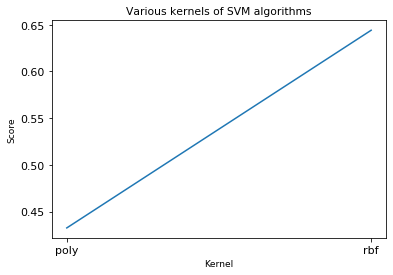

Maximum kernel Score is 64.42%
f1 score of svm: 0.256
Classification report of svm: 
              precision    recall  f1-score   support

     RF00050      0.714     0.627     0.668       375
     RF00059      0.572     0.905     0.701      1097
     RF00162      0.781     0.069     0.127       362
     RF00167      0.747     0.473     0.579       243
     RF00168      0.250     0.010     0.019       100
     RF00174      0.739     0.866     0.798      1270
     RF00234      0.000     0.000     0.000        75
     RF00380      0.000     0.000     0.000        66
     RF00504      0.620     0.784     0.692       644
     RF00521      0.000     0.000     0.000        58
     RF00522      0.000     0.000     0.000        39
     RF00634      0.000     0.000     0.000        67
     RF01051      0.517     0.494     0.505       312
     RF01054      0.000     0.000     0.000         7
     RF01055      0.000     0.000     0.000        82
     RF01057      0.000     0.000     0.000       

/home/liuchong/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/liuchong/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [14]:
print('svm_im')
print('----------------------------------------------------------------')
svm_im = svm_im(x_train, y_train, x_test, y_test)

## Random forest test

In [20]:
print('random forest')
print('----------------------------------------------------------------')
random = random_forest(x_train, y_train, x_test, y_test, dict)

random forest
----------------------------------------------------------------
Test score: 0.81
f1 score of random_forest: 0.739
Classification report of random_forest: 
              precision    recall  f1-score   support

     RF00050      0.789     0.787     0.788       375
     RF00059      0.804     0.861     0.832      1097
     RF00162      0.670     0.652     0.661       362
     RF00167      0.827     0.786     0.806       243
     RF00168      0.638     0.600     0.619       100
     RF00174      0.897     0.884     0.891      1270
     RF00234      0.531     0.693     0.601        75
     RF00380      0.842     0.727     0.780        66
     RF00504      0.829     0.758     0.792       644
     RF00521      0.814     0.828     0.821        58
     RF00522      0.974     0.974     0.974        39
     RF00634      0.680     0.761     0.718        67
     RF01051      0.805     0.795     0.800       312
     RF01054      0.600     0.429     0.500         7
     RF01055      0

In [21]:
print('random_forest_im')
print('----------------------------------------------------------------')
random_im = random_forest_im(x_train, y_train, x_test, y_test)

random_forest_im
----------------------------------------------------------------
Test score: 0.80
f1 score of random_forest: 0.672
Classification report of random_forest: 
              precision    recall  f1-score   support

     RF00050      0.775     0.773     0.774       375
     RF00059      0.760     0.892     0.820      1097
     RF00162      0.706     0.602     0.650       362
     RF00167      0.834     0.765     0.798       243
     RF00168      0.710     0.490     0.580       100
     RF00174      0.853     0.911     0.881      1270
     RF00234      0.673     0.467     0.551        75
     RF00380      0.872     0.515     0.648        66
     RF00504      0.782     0.787     0.785       644
     RF00521      0.830     0.672     0.743        58
     RF00522      0.974     0.974     0.974        39
     RF00634      0.830     0.657     0.733        67
     RF01051      0.800     0.744     0.771       312
     RF01054      0.000     0.000     0.000         7
     RF01055    

In [22]:
print('random forest not majority')
print('----------------------------------------------------------------')
random_test1 = random_forest(x_train, y_train, x_test, y_test, 'not majority')

random forest not majority
----------------------------------------------------------------
Test score: 0.81
f1 score of random_forest: 0.738
Classification report of random_forest: 
              precision    recall  f1-score   support

     RF00050      0.784     0.795     0.789       375
     RF00059      0.825     0.845     0.835      1097
     RF00162      0.676     0.674     0.675       362
     RF00167      0.803     0.786     0.794       243
     RF00168      0.603     0.700     0.648       100
     RF00174      0.919     0.870     0.894      1270
     RF00234      0.538     0.667     0.595        75
     RF00380      0.770     0.712     0.740        66
     RF00504      0.804     0.778     0.791       644
     RF00521      0.787     0.828     0.807        58
     RF00522      0.974     0.974     0.974        39
     RF00634      0.704     0.746     0.725        67
     RF01051      0.783     0.798     0.790       312
     RF01054      0.500     0.429     0.462         7
     R

In [23]:
print('random forest_classweight')
print('----------------------------------------------------------------')
random_test2 = random_forest(x_train, y_train, x_test, y_test, dict, 'balanced')

random forest_classweight
----------------------------------------------------------------
Test score: 0.80
f1 score of random_forest: 0.724
Classification report of random_forest: 
              precision    recall  f1-score   support

     RF00050      0.792     0.773     0.783       375
     RF00059      0.794     0.851     0.821      1097
     RF00162      0.663     0.646     0.655       362
     RF00167      0.801     0.778     0.789       243
     RF00168      0.652     0.580     0.614       100
     RF00174      0.890     0.880     0.885      1270
     RF00234      0.510     0.667     0.578        75
     RF00380      0.814     0.727     0.768        66
     RF00504      0.825     0.755     0.788       644
     RF00521      0.817     0.845     0.831        58
     RF00522      0.974     0.974     0.974        39
     RF00634      0.689     0.761     0.723        67
     RF01051      0.794     0.792     0.793       312
     RF01054      0.400     0.286     0.333         7
     RF

In [24]:
print('random forest_im_classweight')
print('----------------------------------------------------------------')
random_test3 = random_forest_im(x_train, y_train, x_test, y_test, 'balanced')

random forest_im_classweight
----------------------------------------------------------------
Test score: 0.79
f1 score of random_forest: 0.690
Classification report of random_forest: 
              precision    recall  f1-score   support

     RF00050      0.794     0.749     0.771       375
     RF00059      0.754     0.888     0.816      1097
     RF00162      0.712     0.602     0.653       362
     RF00167      0.828     0.753     0.789       243
     RF00168      0.706     0.480     0.571       100
     RF00174      0.839     0.905     0.870      1270
     RF00234      0.635     0.440     0.520        75
     RF00380      0.850     0.515     0.642        66
     RF00504      0.812     0.772     0.791       644
     RF00521      0.796     0.741     0.768        58
     RF00522      0.974     0.949     0.961        39
     RF00634      0.807     0.687     0.742        67
     RF01051      0.805     0.756     0.780       312
     RF01054      0.333     0.143     0.200         7
    

## Gradient Boosting

In [9]:
gb = gradient_boosting(x_train, y_train, x_test, y_test, dict)

Accuracy on test set:0.767
f1 score of gb: 0.653
Classification report of gb: 
              precision    recall  f1-score   support

     RF00050      0.764     0.725     0.744       375
     RF00059      0.782     0.829     0.804      1097
     RF00162      0.626     0.624     0.625       362
     RF00167      0.749     0.737     0.743       243
     RF00168      0.511     0.470     0.490       100
     RF00174      0.873     0.880     0.877      1270
     RF00234      0.463     0.493     0.477        75
     RF00380      0.600     0.455     0.517        66
     RF00504      0.789     0.766     0.777       644
     RF00521      0.745     0.603     0.667        58
     RF00522      0.974     0.974     0.974        39
     RF00634      0.688     0.657     0.672        67
     RF01051      0.745     0.740     0.743       312
     RF01054      0.375     0.429     0.400         7
     RF01055      0.381     0.390     0.386        82
     RF01057      0.561     0.542     0.552        59

 

In [10]:
gb_im = gradient_boosting_im(x_train, y_train, x_test, y_test)

Accuracy on train set:0.776
Accuracy on test set:0.776
f1 score of gbrt: 0.644
Classification report of gbrt: 
              precision    recall  f1-score   support

     RF00050      0.758     0.720     0.739       375
     RF00059      0.761     0.863     0.809      1097
     RF00162      0.671     0.613     0.641       362
     RF00167      0.781     0.749     0.765       243
     RF00168      0.602     0.500     0.546       100
     RF00174      0.859     0.902     0.880      1270
     RF00234      0.518     0.387     0.443        75
     RF00380      0.690     0.439     0.537        66
     RF00504      0.766     0.783     0.774       644
     RF00521      0.829     0.586     0.687        58
     RF00522      0.971     0.872     0.919        39
     RF00634      0.788     0.612     0.689        67
     RF01051      0.773     0.708     0.739       312
     RF01054      0.077     0.143     0.100         7
     RF01055      0.627     0.390     0.481        82
     RF01057      0.667 

## MLP

In [25]:
mlp = mlp(x_train, y_train, x_test, y_test, dict)

Accuracy of mlp model is 0.819
['RF00380' 'RF00059' 'RF00162' ... 'RF01055' 'RF00162' 'RF00504']
0.8187808896210873
f1 score of mlp: 0.749
Classification report of mlp: 
              precision    recall  f1-score   support

     RF00050      0.794     0.800     0.797       375
     RF00059      0.867     0.820     0.843      1097
     RF00162      0.763     0.597     0.670       362
     RF00167      0.786     0.860     0.821       243
     RF00168      0.694     0.500     0.581       100
     RF00174      0.885     0.892     0.889      1270
     RF00234      0.429     0.680     0.526        75
     RF00380      0.706     0.727     0.716        66
     RF00504      0.798     0.863     0.829       644
     RF00521      0.957     0.759     0.846        58
     RF00522      0.949     0.949     0.949        39
     RF00634      0.857     0.716     0.780        67
     RF01051      0.809     0.894     0.849       312
     RF01054      0.600     0.429     0.500         7
     RF01055      0

<function __main__.mlp(x_train, y_train, x_test, y_test, strategy)>

In [26]:
mlp_im = mlp_im(x_train, y_train, x_test, y_test)

Accuracy of mlp_im imbalance model is 0.837
['RF00380' 'RF00059' 'RF00162' ... 'RF01055' 'RF00162' 'RF00504']
0.8371087314662273
f1 score of mlp: 0.749
Classification report of mlp: 
              precision    recall  f1-score   support

     RF00050      0.794     0.800     0.797       375
     RF00059      0.867     0.820     0.843      1097
     RF00162      0.763     0.597     0.670       362
     RF00167      0.786     0.860     0.821       243
     RF00168      0.694     0.500     0.581       100
     RF00174      0.885     0.892     0.889      1270
     RF00234      0.429     0.680     0.526        75
     RF00380      0.706     0.727     0.716        66
     RF00504      0.798     0.863     0.829       644
     RF00521      0.957     0.759     0.846        58
     RF00522      0.949     0.949     0.949        39
     RF00634      0.857     0.716     0.780        67
     RF01051      0.809     0.894     0.849       312
     RF01054      0.600     0.429     0.500         7
     R

In [27]:
print_report('mlp_im_test', mlp_im, x_train, y_train)

f1 score of mlp_im_test: 0.963
Classification report of mlp_im_test: 
              precision    recall  f1-score   support

     RF00050      0.964     0.927     0.945       836
     RF00059      0.954     0.947     0.950      2519
     RF00162      0.882     0.902     0.892       879
     RF00167      0.963     0.972     0.968       570
     RF00168      0.982     0.925     0.953       241
     RF00174      0.974     0.979     0.976      3016
     RF00234      0.905     0.955     0.929       200
     RF00380      0.962     0.993     0.977       151
     RF00504      0.949     0.955     0.952      1481
     RF00521      0.991     0.982     0.986       109
     RF00522      1.000     1.000     1.000        77
     RF00634      0.973     0.973     0.973       149
     RF01051      0.983     0.982     0.982       708
     RF01054      1.000     1.000     1.000        32
     RF01055      0.954     0.932     0.943       221
     RF01057      0.979     0.993     0.986       139

    accura

## NB test

In [37]:
print('nb')
print('-------------------------------------------------------')
nb = naive_bayes(x_train, y_train, x_test, y_test, dict)

nb
-------------------------------------------------------
Accuracy of Naive Bayes: 52.92%
f1 score of nb: 0.468
Classification report of nb: 
              precision    recall  f1-score   support

     RF00050      0.548     0.488     0.516       375
     RF00059      0.842     0.419     0.560      1097
     RF00162      0.413     0.586     0.485       362
     RF00167      0.443     0.527     0.481       243
     RF00168      0.232     0.700     0.348       100
     RF00174      0.876     0.561     0.684      1270
     RF00234      0.172     0.427     0.245        75
     RF00380      0.280     0.712     0.402        66
     RF00504      0.618     0.424     0.503       644
     RF00521      0.556     0.776     0.647        58
     RF00522      0.881     0.949     0.914        39
     RF00634      0.199     0.806     0.319        67
     RF01051      0.518     0.750     0.613       312
     RF01054      0.057     0.714     0.106         7
     RF01055      0.307     0.524     0.387   

In [29]:
print('nb_im')
print('-------------------------------------------------------')
nb_im = naive_bayes_im(x_train, y_train, x_test, y_test)

nb_im
-------------------------------------------------------
Accuracy of Naive Bayes: 55.23%
f1 score of nb: 0.473
Classification report of nb: 
              precision    recall  f1-score   support

     RF00050      0.536     0.483     0.508       375
     RF00059      0.785     0.512     0.620      1097
     RF00162      0.470     0.536     0.501       362
     RF00167      0.457     0.436     0.446       243
     RF00168      0.234     0.700     0.351       100
     RF00174      0.868     0.594     0.706      1270
     RF00234      0.158     0.213     0.182        75
     RF00380      0.274     0.727     0.398        66
     RF00504      0.595     0.452     0.514       644
     RF00521      0.560     0.879     0.685        58
     RF00522      0.841     0.949     0.892        39
     RF00634      0.207     0.821     0.330        67
     RF01051      0.517     0.772     0.620       312
     RF01054      0.057     0.857     0.107         7
     RF01055      0.374     0.415     0.393

## Three methods comparison

In [168]:
best = make_pipeline(SMOTE(random_state = 5), KNeighborsClassifier(n_neighbors=10))
scores = cross_validate(best, x_train, y_train, scoring = scoring, cv = 5, n_jobs=10)
print(scores)
best.fit(x_train, y_train)
best.score(x_test, y_test)
best_pred = best.predict(x_test)
# f1 score
print("f1 score of best: {:.2f}".format(f1_score(y_test,best_pred, average = 'macro')))
# 模型评估报告
print("Classification report of best: \n{}".format(classification_report(y_test, best_pred,
                                        target_names= label)))
best_proba = best.predict_proba(x_test)

{'fit_time': array([1.36815619, 1.38522267, 1.27516413, 1.46671844, 1.39341235]), 'score_time': array([65.77883387, 66.15830994, 64.95893312, 67.77423406, 66.04027724]), 'test_precision_macro': array([0.45819163, 0.48098308, 0.45682151, 0.47233651, 0.47222897]), 'test_recall_macro': array([0.69405591, 0.69335485, 0.67254681, 0.7193012 , 0.69062105]), 'test_f1_macro': array([0.46983322, 0.4947362 , 0.46601983, 0.49063489, 0.4851479 ])}
f1 score of best: 0.50
Classification report of best: 
              precision    recall  f1-score   support

     RF00050       0.62      0.79      0.69       359
     RF00059       0.95      0.43      0.59      1083
     RF00162       0.44      0.80      0.57       365
     RF00167       0.54      0.73      0.62       244
     RF00168       0.14      0.66      0.23        88
     RF00174       1.00      0.33      0.49      1277
     RF00234       0.25      0.71      0.37        90
     RF00380       0.20      0.79      0.32        63
     RF00504       

In [170]:
best2 = KNeighborsClassifier(n_neighbors=16)
scores2 = cross_validate(best2, x_train, y_train, scoring = scoring, cv = 5, n_jobs=10)
print(scores2)
best2.fit(x_train, y_train)
best2.score(x_test, y_test)
best2_pred = best2.predict(x_test)
# f1 score
print("f1 score of best3: {:.2f}".format(f1_score(y_test,best2_pred, average = 'macro')))
# 模型评估报告
print("Classification report of best2: \n{}".format(classification_report(y_test, best2_pred,
                                        target_names= label)))
best2_proba = best2.predict_proba(x_test)

{'fit_time': array([0.04368973, 0.04368138, 0.04063821, 0.04307175, 0.04468369]), 'score_time': array([11.63832211, 11.69619298, 12.09875536, 11.89288187, 11.96761632]), 'test_precision_macro': array([0.76222982, 0.77800996, 0.71748333, 0.7782801 , 0.79469287]), 'test_recall_macro': array([0.51248768, 0.5246983 , 0.50299728, 0.52320519, 0.49453976]), 'test_f1_macro': array([0.5736022 , 0.57565019, 0.55515465, 0.5859372 , 0.55578544])}
f1 score of best3: 0.60
Classification report of best2: 
              precision    recall  f1-score   support

     RF00050       0.83      0.78      0.81       359
     RF00059       0.79      0.92      0.85      1083
     RF00162       0.65      0.74      0.69       365
     RF00167       0.86      0.59      0.70       244
     RF00168       0.57      0.48      0.52        88
     RF00174       0.88      0.87      0.88      1277
     RF00234       0.80      0.27      0.40        90
     RF00380       0.79      0.48      0.59        63
     RF00504     

In [171]:
over_samples_train = SMOTEENN(random_state=5, n_jobs=5)
x_train_s, y_train_s = over_samples_train.fit_sample(x_train, y_train)
best3 = KNeighborsClassifier(n_neighbors=16)
scores3 = cross_validate(best3, x_train_s, y_train_s, scoring = scoring, cv = 5, n_jobs=10)
print(scores3)
best3.fit(x_train_s, y_train_s)
best3.score(x_test, y_test)

best3_pred = best3.predict(x_test)
# f1 score
print("f1 score of best3: {:.2f}".format(f1_score(y_test,best3_pred, average = 'macro')))
# 模型评估报告
print("Classification report of best3: \n{}".format(classification_report(y_test, best3_pred,
                                        target_names= label)))
best3_proba = best3.predict_proba(x_test)

{'fit_time': array([0.22312522, 0.29851818, 0.29342937, 0.18135238, 0.28857732]), 'score_time': array([168.14797163, 165.46073842, 166.19052601, 162.7279706 ,
       163.33171201]), 'test_precision_macro': array([0.95304545, 0.96063604, 0.95937588, 0.9568318 , 0.95625031]), 'test_recall_macro': array([0.91273627, 0.92393875, 0.91939974, 0.90468659, 0.90314451]), 'test_f1_macro': array([0.92442428, 0.93549652, 0.93110554, 0.91621002, 0.91123336])}
f1 score of best3: 0.46
Classification report of best3: 
              precision    recall  f1-score   support

     RF00050       0.55      0.79      0.65       359
     RF00059       0.98      0.26      0.41      1083
     RF00162       0.40      0.80      0.53       365
     RF00167       0.50      0.72      0.59       244
     RF00168       0.11      0.66      0.19        88
     RF00174       1.00      0.17      0.30      1277
     RF00234       0.24      0.73      0.36        90
     RF00380       0.17      0.78      0.28        63
     

,A,C,G,U,AA,AC,AG,AU,CA,CC,...,GCUGAG,GCCACU,GCCUCC,GCCGAA,GGAAGG,GGAGAG,GGCUGA,GGCGGU,GGGAAG,GGGUGC
Class,,,,,,,,,,,,,,,,,,,,,
RF00522,0.11,0.047619,0.008929,0.072165,0.166667,0.086957,0.028571,0.129032,0.100000,0.064516,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
RF00167,0.23,0.085714,0.169643,0.288660,0.194444,0.130435,0.142857,0.322581,0.066667,0.096774,...,0.0,0.0,0.000000,0.000000,0.333333,0.0,0.0,0.0,0.0,0.0
RF00174,0.36,0.571429,0.491071,0.257732,0.250000,0.652174,0.342857,0.161290,0.333333,0.677419,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
RF01055,0.23,0.238095,0.303571,0.185567,0.194444,0.347826,0.200000,0.161290,0.166667,0.258065,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
RF00059,0.22,0.114286,0.178571,0.195876,0.194444,0.217391,0.228571,0.161290,0.133333,0.096774,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RF00059,0.23,0.257143,0.258929,0.278351,0.111111,0.391304,0.228571,0.258065,0.200000,0.258065,...,0.0,0.0,0.333333,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
RF00167,0.11,0.085714,0.080357,0.154639,0.138889,0.217391,0.000000,0.161290,0.066667,0.161290,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
RF00059,0.10,0.180952,0.267857,0.164948,0.055556,0.130435,0.257143,0.064516,0.066667,0.225806,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.5
